In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [7]:
np.random.seed(44)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

class Rectangle:
    def __init__(self, center=(0.0, 0.0), width=2.0, height=1.0, theta=0.0):
        self.cx, self.cy = center
        self.hw = width / 2
        self.hh = height / 2
        self.theta = theta  # in radians, counter-clockwise from the positive x-axis
        self.latest_points = None
        self._points_distance_ls = None
        self._points_side_ls = None

    def get_corners(self):
        hw, hh = self.hw, self.hh
        corners = np.array([
            [-hw, -hh],  # bottom-left
            [-hw,  hh],  # top-left
            [ hw,  hh],  # top-right
            [ hw, -hh],  # bottom-right
        ])
        R = np.array([
            [np.cos(self.theta), -np.sin(self.theta)],
            [np.sin(self.theta),  np.cos(self.theta)]
        ])
        rotated = corners @ R.T
        rotated += np.array([self.cx, self.cy])
        return rotated  # shape (4, 2)

    def get_sides(self):
        c = self.get_corners()
        return {
            'left':   (c[0], c[1]),
            'top':    (c[1], c[2]),
            'right':  (c[2], c[3]),
            'bottom': (c[3], c[0]),
        }

    def move(self, dx=0.0, dy=0.0):
        self.cx += dx
        self.cy += dy

    def plot(self, ax=None, **kwargs):
        if ax is None:
            ax = plt.gca()
        corners = self.get_corners()
        corners = np.vstack([corners, corners[0]])  # close the loop
        ax.plot(corners[:, 0], corners[:, 1], **kwargs)
        ax.set_aspect('equal')


    @staticmethod
    def _cross(v1, v2):
        """
        Cross product helper function
        +: counter-clockwise, -: clockwise, 0: collinear
        """
        return v1[0] * v2[1] - v1[1] * v2[0]
    
            
    @staticmethod    
    def _point_to_segment_distance_with_closest( p, a, b):
        ap = p - a
        ab = b - a
        t = np.dot(ap, ab) / np.dot(ab, ab)
        t = np.clip(t, 0, 1)
        closest = a + t * ab
        return np.linalg.norm(p - closest), closest

        
    def _point_distance_to_all_sides(self, point):
        """
        Calculate distance from point to all four sides of rectangle
        Returns the minimum distance and corresponding side
        """
        sides = self.get_sides()
        distances = {}
        closest_points = {}
        
        # Calculate distance to each side
        for side_name, (a, b) in sides.items():
            dist, closest = self._point_to_segment_distance_with_closest(
                np.array(point), a, b)
            distances[side_name] = dist
            closest_points[side_name] = closest
        
        # Find minimum distance
        min_side = min(distances, key=distances.get)
        min_distance = distances[min_side]
        closest_point = closest_points[min_side]
        return min_side, min_distance, closest_point

    def points_distance(self, points, distance_only=True):
        """
        Improved version that computes distance to nearest side correctly
        """
        self.latest_points = points
        points = np.atleast_2d(points)

        results = []
        
        for point in points:
            side, dist, closest_point = self._point_distance_to_all_sides(point)
            results.append((side, dist, closest_point))
        
        distances = np.array([r[1] for r in results])
        sides = [r[0] for r in results]
        
        self._points_distance_ls = distances
        self._points_side_ls = sides
        
        if distance_only:
            return distances
        else:
            return distances, results
        
    def get_mean_dist(self, points):
        # print("Latest points:", self.latest_points, type(self.latest_points))
        # print("Current points:", points, type(points))
        if self.latest_points is None or not np.array_equal(np.array(self.latest_points), np.array(points)):
            # print("Computing distances for new points")
            self.points_distance(points)
        return np.mean(self._points_distance_ls)
    
    def get_distance_list(self, points):
        if self._points_distance_ls is None or not np.array_equal(np.array(self.latest_points), np.array(points)):
            self.points_distance(points)
        return self._points_distance_ls
    
    def get_side_list(self, points):
        
        if self._points_side_ls is None or not np.array_equal(np.array(self.latest_points), np.array(points)):
            self.points_distance(points)
        return self._points_side_ls
        

    def sample_points(self, num_points=10, jitter=0.0):
        sides = self.get_sides()
        points = []

        for _ in range(num_points):
            side_name = np.random.choice(list(sides.keys()))
            p1, p2 = sides[side_name]
            alpha = np.random.uniform(0, 1)
            point = (1 - alpha) * p1 + alpha * p2
            if jitter > 0:
                point += np.random.normal(scale=jitter, size=2)
            points.append(point)

        return np.array(points)        

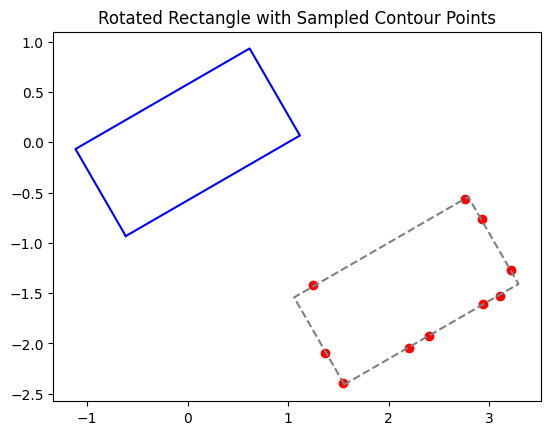

In [12]:
rect_original = Rectangle(center=(0, 0), width=2.0, height=1.0, theta=np.pi/6)
rect = Rectangle(center=(0, 0), width=2.0, height=1.0, theta=np.pi/6)

offsetX, offsetY = np.random.uniform(-2, 3), np.random.uniform(-2, 3)
# offsetX, offsetY = 2, 1
rect.move(offsetX, offsetY)
points = rect.sample_points(num_points=10, jitter=0.01)

fig, ax = plt.subplots()
rect_original.plot(ax, color = "blue")
rect.plot(ax, color='gray', linestyle='--')
ax.scatter(points[:, 0], points[:, 1], color='red')
ax.set_title("Rotated Rectangle with Sampled Contour Points")
plt.show()


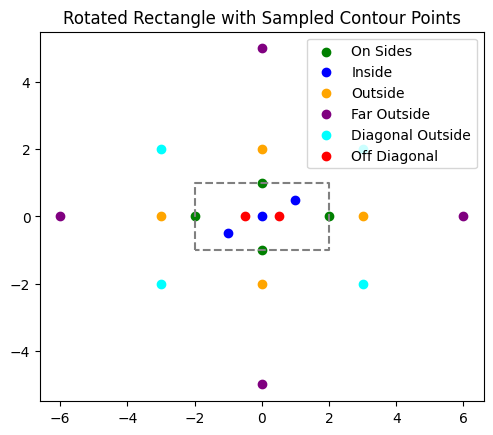

All tests passed!


In [13]:
import numpy as np

def test_rectangle_distance():
    """
    Test the distance computation for the Rectangle class.
    """
    rect = Rectangle(center=(0, 0), width=4.0, height=2.0, theta=0.0)


    # Test points exactly on the sides of the rectangle
    points_on_sides = np.array([
        [0, 1],   # Top side
        [0, -1],  # Bottom side
        [2, 0],   # Right side
        [-2, 0],  # Left side
    ])
    # Test points inside the rectangle but not on the sides
    points_inside = np.array([
        [0, 0],    # Center of the rectangle
        [1, 0.5],  # Inside, closer to the top-right
        [-1, -0.5] # Inside, closer to the bottom-left
    ])
    # Test points outside the rectangle
    points_outside = np.array([
        [0, 2],    # Above the top side
        [0, -2],   # Below the bottom side
        [3, 0],    # To the right of the right side
        [-3, 0],   # To the left of the left side
    ])
    # Test points far outside the rectangle
    points_far_outside = np.array([
        [0, 5],    # Far above the top side
        [0, -5],   # Far below the bottom side
        [6, 0],    # Far to the right of the right side
        [-6, 0],   # Far to the left of the left side
    ])
    # Test points diagonally outside the rectangle
    points_diagonal = np.array([
        [3, 2],    # Top-right diagonal
        [-3, 2],   # Top-left diagonal
        [3, -2],   # Bottom-right diagonal
        [-3, -2],  # Bottom-left diagonal
    ])
    points_off_diagonal = np.array([
        [-0.5, 0],    # Diagonal to the right of the rectangle
        [0.5, 0],   # Diagonal to the left of the rectangle

    ])
    fig, ax = plt.subplots()
    rect.plot(ax, color='gray', linestyle='--')
    ax.scatter(points_on_sides[:, 0], points_on_sides[:, 1], color='green', label='On Sides')
    ax.scatter(points_inside[:, 0], points_inside[:, 1], color='blue', label='Inside')
    ax.scatter(points_outside[:, 0], points_outside[:, 1], color='orange', label='Outside')
    ax.scatter(points_far_outside[:, 0], points_far_outside[:, 1], color='purple', label='Far Outside')
    ax.scatter(points_diagonal[:, 0], points_diagonal[:, 1], color='cyan', label='Diagonal Outside')
    ax.scatter(points_off_diagonal[:, 0], points_off_diagonal[:, 1], color='red', label='Off Diagonal')
    ax.legend()
    ax.set_title("Rotated Rectangle with Sampled Contour Points")
    plt.show()

    distances = rect.points_distance(points_on_sides)
    expected_distances = [0.0, 0.0, 0.0, 0.0]
    assert np.allclose(distances, expected_distances), (
        f"Distances for points on sides are incorrect. "
        f"Computed: {distances}, Expected: {expected_distances}"
    )

    # Test points exactly on the corners of the rectangle
    corners = rect.get_corners()
    distances = rect.points_distance(corners)
    expected_distances = [0.0, 0.0, 0.0, 0.0]
    assert np.allclose(distances, expected_distances), (
        f"Distances for points on corners are incorrect. "
        f"Computed: {distances}, Expected: {expected_distances}"
    )
    # Test points inside the rectangle
    distances = rect.points_distance(points_inside)
    expected_distances = [1.0, 0.5, 0.5]
    assert np.allclose(distances, expected_distances), (
        f"Distances for points inside the rectangle are incorrect. "
        f"Computed: {distances}, Expected: {expected_distances}"
    )

    
    distances = rect.points_distance(points_outside)
    expected_distances = [1.0, 1.0, 1.0, 1.0]  # All points are 1 unit away from the closest side
    assert np.allclose(distances, expected_distances), (
        f"Distances for points outside the rectangle are incorrect. "
        f"Computed: {distances}, Expected: {expected_distances}"
    )
    
    
    distances = rect.points_distance(points_far_outside)
    expected_distances = [4.0, 4.0, 4.0, 4.0]  # All points are 4 units away from the closest side
    assert np.allclose(distances, expected_distances), (
        f"Distances for far points outside the rectangle are incorrect. "
        f"Computed: {distances}, Expected: {expected_distances}"
    )

    
    distances = rect.points_distance(points_diagonal)
    expected_distances = [np.sqrt(2), np.sqrt(2), np.sqrt(2), np.sqrt(2)]  # Diagonal distances
    assert np.allclose(distances, expected_distances), (
        f"Distances for diagonally outside points are incorrect. "
        f"Computed: {distances}, Expected: {expected_distances}"
    )

    distances = rect.points_distance(points_off_diagonal)
    expected_distances = [1, 1]  
    assert np.allclose(distances, expected_distances), (
        f"Distances for off diagonal points are incorrect. "
        f"Computed: {distances}, Expected: {expected_distances}"
    )

    print("All tests passed!")

# Run the test
test_rectangle_distance()

In [14]:
rect.points_distance(points=points, distance_only=False)

(array([0.00488514, 0.01051264, 0.00141793, 0.01116036, 0.00173966,
        0.00948822, 0.00508634, 0.01115935, 0.00712778, 0.00297262]),
 [('bottom',
   np.float64(0.004885139111123017),
   array([ 2.19452406, -2.04164185])),
  ('left', np.float64(0.01051263943003013), array([ 1.37322185, -2.08866602])),
  ('bottom',
   np.float64(0.001417934326203062),
   array([ 2.94101186, -1.61065691])),
  ('top', np.float64(0.01116036125993336), array([ 1.24845632, -1.43315377])),
  ('left',
   np.float64(0.0017396620830018319),
   array([ 1.55039018, -2.39553056])),
  ('right',
   np.float64(0.009488221410376979),
   array([ 2.9199228 , -0.76763065])),
  ('right',
   np.float64(0.00508634121812125),
   array([ 3.21262922, -1.27461304])),
  ('bottom',
   np.float64(0.01115934550546714),
   array([ 3.10235423, -1.51750586])),
  ('top', np.float64(0.007127782882647234), array([ 2.75806439, -0.56158115])),
  ('bottom',
   np.float64(0.0029726222449842476),
   array([ 2.39675347, -1.92488465]))])

In [15]:
list(rect_original.get_sides().values())

[(array([-0.6160254, -0.9330127]), array([-1.1160254, -0.0669873])),
 (array([-1.1160254, -0.0669873]), array([0.6160254, 0.9330127])),
 (array([0.6160254, 0.9330127]), array([1.1160254, 0.0669873])),
 (array([1.1160254, 0.0669873]), array([-0.6160254, -0.9330127]))]

In [ ]:
matrix =[
 ["1","0","1","0","0"],
 ["1","0","1","1","1"],
 ["1","1","1","1","1"],
 ["1","0","0","1","0"]]
def find_largest_square(matrix):
    if not matrix or not matrix[0]:
        return 0
    s = [[0] * len(matrix[0]) for _ in range(len(matrix))]
    max_side = 0
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j] == "1":
                if i == 0 or j == 0:
                    s[i][j] = 1
                else:
                    s[i][j] = min(s[i-1][j], s[i][j-1], s[i-1][j-1]) + 1
    return max(max(row) for row in s) ** 2

In [16]:
# rect_original.point_distance_to_side([4,1]
np.mean(rect_original.points_distance(points=points, distance_only=True))
# [1, 2]

np.float64(2.1720645739909115)

In [17]:
rect_original.get_mean_dist(points)

np.float64(2.1720645739909115)

In [19]:
rect_original.get_mean_dist(points)

np.float64(2.1720645739909115)

In [20]:
class StepOptimizer:
    def __init__(self, tau=0.1, loss='soft_l1', bounds=None, k_softmin=None):
        self.tau = tau
        self.loss = loss
        self.bounds = bounds  # e.g., (-0.5, 0.5)
        self.k_softmin = k_softmin  # if you choose soft-min instead of hinge

    def _validate_inputs(self, rect, points, direction):
        if not isinstance(rect, Rectangle):
            raise ValueError("rect must be an instance of Rectangle")
        if not isinstance(points, np.ndarray) or points.ndim != 2 or points.shape[1] != 2:
            raise ValueError("points must be a 2D numpy array with shape (n, 2)")
        if direction not in ["vertical", "horizontal"]:
            raise ValueError("direction must be either 'vertical' or 'horizontal'")

    def _residuals(self, t, points, direction, rect = Rectangle):
        """
        t: [shift] (scalar array)
        direction: 'vertical' or 'horizontal'
        returns vector of residuals r_i = max(0, d_i(shift) - tau)
        """
        # actually t = [shift]*len(points) 
        shift = float(t[0])
        if direction == "vertical":
            pts = np.c_[points[:, 0], points[:, 1] + shift]

        elif direction == "horizontal":
            pts = np.c_[points[:, 0] + shift, points[:, 1]]

        distance_new = rect.points_distance(pts, distance_only=True)  
        # Hinge-to-threshold residuals (least-squares-friendly):
        return np.maximum(0.0, distance_new)


    def run(self, rect, points, direction, max_nfev):
        self._validate_inputs(rect, points, direction)
        x0 = np.array([0.0])
        fun = lambda t: self._residuals(t, points, direction, rect=rect)
        res = least_squares(fun, x0, method='trf', loss=self.loss,
                            max_nfev=max_nfev,
                            bounds=self.bounds if self.bounds is not None else (-np.inf, np.inf))
        delta = float(res.x[0])
        used = res.nfev
        return used, delta



In [23]:
class RectangleEnv:
    def __init__(self, rect_params, optimizer_params, points):
        self.rect_params = rect_params
        self.optimizer_params = optimizer_params
        self.starting_points = points
        self.points = points
        self.max_steps = 100
        self.steps = 0
        self.latest_used_iters = None
        self.tau = optimizer_params.get('tau', 0.1)  # default tau
        self.close = 0.4
        self.actions = [
            ("vertical", 2),
            ("vertical", 4),
            ("vertical", 6),
            ("horizontal", 2),
            ("horizontal", 4),
            ("horizontal", 6),
        ]
        self.rectangle = Rectangle(**rect_params)
        self.optimizer = StepOptimizer(**optimizer_params)
        self._old_dist = self.rectangle.get_mean_dist(points=self.points)

    def reset(self):
        self.rectangle = Rectangle(**self.rect_params)
        self.points = self.starting_points.copy()
        self.steps = 0
        self.latest_used_iters = 0
        self._old_dist = self.rectangle.get_mean_dist(points=self.points)
        return self.encode_state()


    def apply_action(self, action_id):
        action = self.actions[action_id]
        direction, steps = action

        used, delta = self.optimizer.run(
            self.rectangle, self.points, direction, max_nfev=steps
        )
        print(f"Action: {action}, Used: {used}, Delta: {delta}")

        if direction == "vertical":
            # self.rectangle.move(dy=delta)
            self.points[:, 1] += delta
        elif direction == "horizontal":
            # self.rectangle.move(dx=delta)
            self.points[:, 0] += delta
        self.latest_used_iters = used

    def step(self, action):
        self.apply_action(action)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_terminal()
        self.render()
        return self.encode_state(), reward, done

    def compute_reward(self, alpha=1.0, beta=0.1):
        new_dist = self.rectangle.get_mean_dist(points=self.points)
        reward = alpha * (self._old_dist - new_dist) - beta * self.latest_used_iters
        # Update memory so next step compares to this state's distance
        self._old_dist = new_dist
        return reward
    
    def encode_state(self):
        # Count by closest side
        side_counts = Counter(self.rectangle.get_side_list(points=self.points))  # e.g., ["top","left",...]
        num_top = side_counts.get("top", 0)
        num_bottom = side_counts.get("bottom", 0)
        num_right = side_counts.get("right", 0)
        num_left = side_counts.get("left", 0)

        # Bin distances: 0=touching (<tau), 1=close ([tau, close)), 2=far (>=close)
        d = self.rectangle.get_distance_list(points=self.points)
        binned = [0 if x < self.tau else (1 if x < self.close else 2) for x in d]

        dist_counts = Counter(binned)
        num_touching = dist_counts.get(0, 0)
        num_close = dist_counts.get(1, 0)
        num_far = dist_counts.get(2, 0)

        # Optional safety checks (can disable in prod)
        N = len(d)
        assert (
            num_top + num_bottom + num_right + num_left
        ) == N, "side counts mismatch"
        assert (num_touching + num_close + num_far) == N, "distance counts mismatch"

        return (
            num_top,
            num_bottom,
            num_right,
            num_left,
            num_touching,
            num_close,
            num_far,
        )

    def is_terminal(self):
        distances = np.array(self.rectangle.points_distance(points=self.points))
        all_touching = np.all(distances < self.tau)  # match binning rule
        return all_touching or (self.steps >= self.max_steps)

    def render(self):
        fig, ax = plt.subplots()
        self.rectangle.plot(ax, color="gray")
        ax.scatter(self.points[:, 0], self.points[:, 1], color="red")
        ax.set_title(f"Step {self.steps}")
        plt.show()

In [10]:
# ==== DEMO ====
if __name__ == "__main__":
    # Initial rectangle far from points
    rect_params = dict(center=(0, 0), width=2.0, height=1.0, theta=0.0)
    points = np.array([[3.0, 3.0], [3.2, 3.1], [2.8, 3.2]])

    env = RectangleEnv(rect_params, points)

    state = env.reset()
    done = False
    i = 0
    while i<=20:
        action = np.random.choice([0, 1])  # random move
        state, reward, done = env.step(action)
        print(f"Step {env.steps}, State={state:.3f}, Reward={reward:.3f}, Done={done}")
        env.render()
        i += 1
        if done:
            print("Reached terminal state.")
            break

TypeError: RectangleEnv.__init__() missing 1 required positional argument: 'points'

Step 1: horizontal, shift=-1.999997934723917, used_iters=16
Step 2: vertical, shift=-0.5000000163044167, used_iters=10


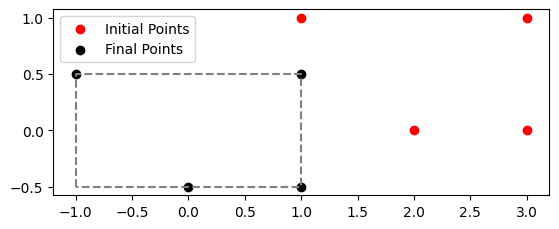

In [11]:
def sanity_check_step_optimizer():
    """
    Sanity check for StepOptimizer and Rectangle classes.
    Verifies that points are iteratively adjusted to minimize their distance to the rectangle.
    """
    rect = Rectangle(center=(0, 0), width=2.0, height=1.0, theta=0.0)
    _, ax = plt.subplots()
    rect.plot(ax=ax, color='gray', linestyle='--')
    
    # Initial points
    points = np.array([[3.0, 1.0], [3.0, 0.0], [2.0, 0.0], [1.0, 1.0]])
    ax.scatter(points[:, 0], points[:, 1], color="red", label="Initial Points")
    
    # Optimizer setup
    optimizer = StepOptimizer(tau=0.5, loss="soft_l1", bounds=(-3, 3))
    
    max_iter = 0
    while rect.get_mean_dist(points) >= 0.01 and max_iter <= 20:
        used1, delta1 = optimizer.run(
            rect=rect, points=points, direction="horizontal", max_nfev=100
        )
        points[:, 0] += delta1
        max_iter += 1
        print(f"Step {max_iter}: horizontal, shift={delta1}, used_iters={used1}")

        used2, delta2 = optimizer.run(
            rect=rect, points=points, direction="vertical", max_nfev=100
        )
        max_iter += 1
        print(f"Step {max_iter}: vertical, shift={delta2}, used_iters={used2}")
        points[:, 1] += delta2

    # Final points
    ax.scatter(points[:, 0], points[:, 1], color="black", marker="o", label="Final Points")
    ax.legend()
    plt.show()
sanity_check_step_optimizer()

In [12]:
rect.points_distance_ls

NameError: name 'rect' is not defined

In [13]:
rect.points_distance(points=points, distance_only=False)

NameError: name 'rect' is not defined

In [14]:
rect.get_mean_dist(points)

NameError: name 'rect' is not defined

In [15]:
rect.get_sides()

NameError: name 'rect' is not defined

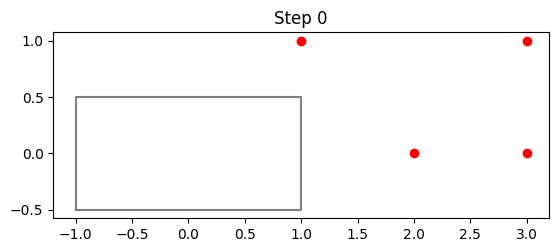


[check] encode_state invariants
Encoded state: (2, 0, 2, 0, 0, 0, 4)
 sides    (T,B,R,L):  2  0  2  0
 distances (touch,close,far):  0  0  4
  sum sides == N: True   sum bins == N: True

[check] axis isolation via apply_action()
Action: ('vertical', 2), Used: 2, Delta: -0.7062212063290513
  vertical: x unchanged? True | y changed? True
Action: ('horizontal', 2), Used: 2, Delta: -1.7320508075688772
  horizontal: y unchanged? True | x changed? True

[run] short rollout using env.step()
 t        action  used   mean_before   mean_after    imprv     reward
------------------------------------------------------------------------
Action: ('horizontal', 2), Used: 2, Delta: -1.7320508075688772


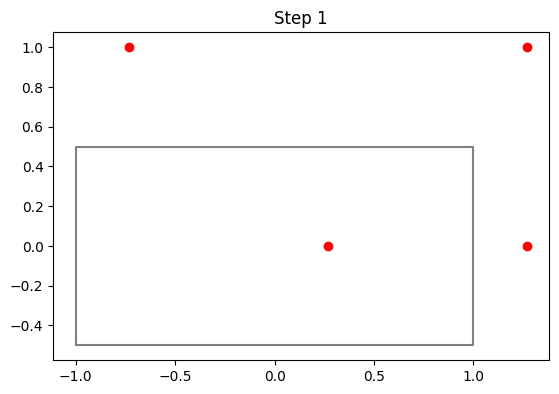

 0  ('horizontal', 2)     2      1.390388     0.458805   0.9316     0.7316
      expected≈ 0.7316  (set compute_reward(alpha=1,beta=0.1) to match)
      invariants: sides_sum==N? True | bins_sum==N? True
Action: ('vertical', 2), Used: 2, Delta: -0.20835708315382584


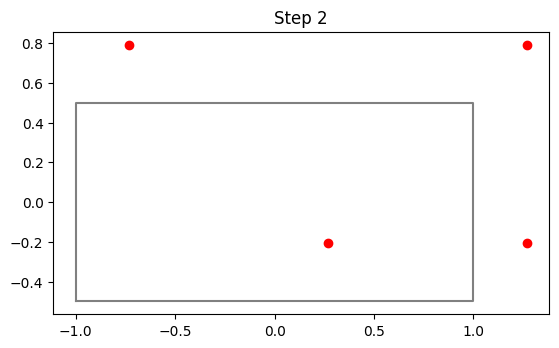

 1  ('vertical', 2)     2      0.458805     0.311820   0.1470    -0.0530
      expected≈ -0.0530  (set compute_reward(alpha=1,beta=0.1) to match)
      invariants: sides_sum==N? True | bins_sum==N? True
Action: ('horizontal', 4), Used: 4, Delta: -0.23722471978214496


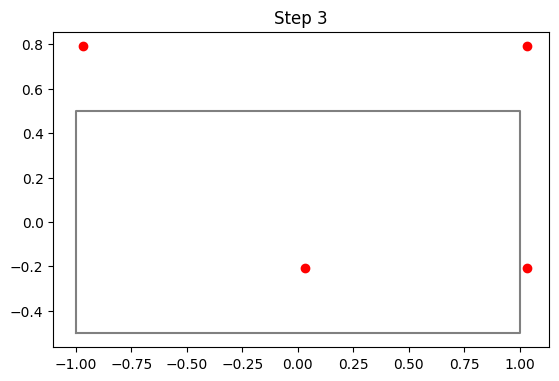

 2  ('horizontal', 4)     4      0.311820     0.226817   0.0850    -0.3150
      expected≈ -0.3150  (set compute_reward(alpha=1,beta=0.1) to match)
      invariants: sides_sum==N? True | bins_sum==N? True
Action: ('vertical', 4), Used: 4, Delta: -0.2906028732865769


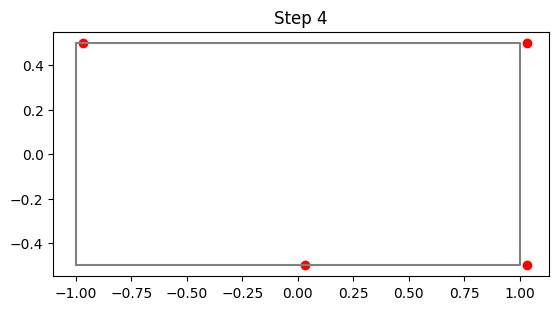

 3  ('vertical', 4)     4      0.226817     0.015887   0.2109    -0.1891
      expected≈ -0.1891  (set compute_reward(alpha=1,beta=0.1) to match)
      invariants: sides_sum==N? True | bins_sum==N? True
  -> done (terminal reached by touching-all or max_steps)

[check] terminal conditions
  all-touching? True  (expect True if your tau <= tiny epsilon)
  max-steps terminal? True  (expect True)

[done] If something looks off (e.g., reward != expected), tweak compute_reward or the alpha/beta used.


In [16]:
# ----------------------- Helpers -----------------------

def make_points_sample():
    """A tiny cloud mostly to the right/top of the rectangle."""
    return np.array([[3.0, 1.0],
                     [3.0, 0.0],
                     [2.0, 0.0],
                     [1.0, 1.0]], dtype=float)

def build_env():
    rect_params = dict(center=(0, 0), width=2.0, height=1.0, theta=0.0)
    optimizer_params = dict(tau=0.5, loss="soft_l1", bounds=(-5, 5))
    pts = make_points_sample()
    env = RectangleEnv(rect_params=rect_params,
                       optimizer_params=optimizer_params,
                       points=pts)
    
    return env

def print_state_tuple(s):
    (num_top, num_bottom, num_right, num_left,
     num_touching, num_close, num_far) = s
    print(f" sides    (T,B,R,L): {num_top:2d} {num_bottom:2d} {num_right:2d} {num_left:2d}")
    print(f" distances (touch,close,far): {num_touching:2d} {num_close:2d} {num_far:2d}")

# ----------------------- Checks -----------------------

def check_encode_state_invariants(env):
    print("\n[check] encode_state invariants")
    s = env.encode_state()
    print(f"Encoded state: {s}")
    N = len(env.points)
    print_state_tuple(s)
    a, b, c, d, e, f, g = s
    ok1 = (a + b + c + d) == N
    ok2 = (e + f + g) == N
    print(f"  sum sides == N: {ok1}   sum bins == N: {ok2}")

def check_axis_isolation(env):
    print("\n[check] axis isolation via apply_action()")
    env.reset()
    x0 = env.points[:, 0].copy()
    y0 = env.points[:, 1].copy()
    env.apply_action(0)  # ("vertical", 2)
    print(f"  vertical: x unchanged? {np.allclose(env.points[:,0], x0)} | y changed? {not np.allclose(env.points[:,1], y0)}")

    env.reset()
    x0 = env.points[:, 0].copy()
    y0 = env.points[:, 1].copy()
    env.apply_action(3)  # ("horizontal", 2)
    print(f"  horizontal: y unchanged? {np.allclose(env.points[:,1], y0)} | x changed? {not np.allclose(env.points[:,0], x0)}")

def rollout_and_print(env, steps=12):
    print("\n[run] short rollout using env.step()")
    env.reset()
    # Compute initial mean distance
    dist_prev = env.rectangle.get_mean_dist(points=env.points)
    print(f"{'t':>2}  {'action':>12}  {'used':>4}  {'mean_before':>12}  {'mean_after':>11}  {'imprv':>7}  {'reward':>9}")
    print("-"*72)

    # Cycle through all 6 actions to exercise budgets/directions
    action_order = [3, 0, 4, 1, 5, 2]  # H2, V2, H4, V4, H6, V6
    for t in range(steps):
        a = action_order[t % len(action_order)]
        direction, budget = env.actions[a]

        # Step once
        state, reward, done = env.step(a)
        # After step(), env._old_dist should reflect the new mean; recompute to be robust
        dist_after = env.rectangle.get_mean_dist(points=env.points)
        used = env.latest_used_iters
        improvement = dist_prev - dist_after

        print(f"{t:2d}  {str((direction,budget)):>12}  {used:4d}  {dist_prev:12.6f}  {dist_after:11.6f}  {improvement:7.4f}  {reward:9.4f}")

        # Optional soft check (printed, not asserted): expected reward if alpha=1, beta=0.1
        expected = improvement - 0.1 * used
        print(f"      expected≈ {expected:.4f}  (set compute_reward(alpha=1,beta=0.1) to match)")

        # Invariants each step
        a1, a2, a3, a4, b1, b2, b3 = state
        N = len(env.points)
        inv1 = (a1 + a2 + a3 + a4) == N
        inv2 = (b1 + b2 + b3) == N
        print(f"      invariants: sides_sum==N? {inv1} | bins_sum==N? {inv2}")

        dist_prev = dist_after
        if done:
            print("  -> done (terminal reached by touching-all or max_steps)")
            break

def check_terminal_conditions(env):
    print("\n[check] terminal conditions")
    # Case: all points exactly on the right edge
    env.reset()
    N = len(env.points)
    env.points[:] = np.array([env.rectangle.x_right if hasattr(env.rectangle, 'x_right') else 1.0,
                              0.0])[None, :].repeat(N, axis=0)
    print(f"  all-touching? {env.is_terminal()}  (expect True if your tau <= tiny epsilon)")

    # Case: max steps
    env.reset()
    env.steps = env.max_steps
    print(f"  max-steps terminal? {env.is_terminal()}  (expect True)")

# ----------------------- Main -----------------------

if __name__ == "__main__":
    env = build_env()
    env.render()

    # 1) state invariants on reset
    env.reset()
    check_encode_state_invariants(env)

    # 2) axis isolation (uses apply_action only)
    check_axis_isolation(env)

    # 3) rollout that prints distances, rewards, and invariants
    rollout_and_print(env, steps=18)

    # 4) terminal checks
    check_terminal_conditions(env)

    print("\n[done] If something looks off (e.g., reward != expected), tweak compute_reward or the alpha/beta used.")

In [21]:
env = build_env()

In [2]:
import numpy as np
from collections import defaultdict
from contextlib import contextmanager

# ----- policy from Q -----
def epsilon_greedy(Q, s, eps, nA):
    if np.random.random() < eps:
        return np.random.randint(nA)
    q = Q[s]
    best = np.flatnonzero(q == q.max())
    return int(np.random.choice(best))

def greedy_action(Q, s):
    return int(np.argmax(Q[s]))

# ----- render control -----
@contextmanager
def suppress_render(env):
    orig = env.render
    env.render = lambda *a, **k: None
    try:
        yield
    finally:
        env.render = orig

# ----- SARSA training -----
def train_sarsa(env, episodes=300, alpha=0.1, gamma=1,
                eps_start=0.2, eps_end=0.01, eps_decay=0.995, seed=0):
    """
    Returns:
      Q: defaultdict[state_tuple] -> np.array(nA)
      logs: list of dicts with per-episode metrics:
            {'return', 'steps', 'iters', 'solved', 'final_mean_dist', 'eps'}
    """
    np.random.seed(seed)
    nA = len(env.actions)
    Q = defaultdict(lambda: np.zeros(nA, dtype=float))
    logs = []

    with suppress_render(env):  # no pop-ups while learning
        for ep in range(episodes):
            s = env.reset()
            eps = max(eps_end, eps_start * (eps_decay ** ep))
            a = epsilon_greedy(Q, s, eps, nA)
    
            G = 0.0
            total_used_iters = 0
            steps = 0
            done = False

            while not done:
                s2, r, done = env.step(a)
                G += r
                steps += 1
                # accumulate optimizer iterations used this step
                total_used_iters += int(env.latest_used_iters or 0)

                if done:
                    target = r
                else:
                    a2 = epsilon_greedy(Q, s2, eps, nA)
                    target = r + gamma * Q[s2][a2]

                Q[s][a] += alpha * (target - Q[s][a])
                s, a = s2, (a2 if not done else a)

            # episode summary
            final_mean_dist = env.rectangle.get_mean_dist(points=env.points)
            solved = bool(np.all(np.array(env.rectangle.points_distance(points=env.points)) < env.tau))
            logs.append({
                'return': G,
                'steps': steps,
                'iters': total_used_iters,
                'solved': solved,
                'final_mean_dist': float(final_mean_dist),
                'eps': eps,
            })
        
    return Q, logs


In [3]:
def run_episode(env, Q, max_steps=100, render=True):
    """
    Runs one episode with greedy policy (ε=0).
    Returns dict: {'return','steps','iters','solved','final_mean_dist'}
    """
    # choose whether to suppress rendering
    class _Null:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    ctx = _Null() if render else suppress_render(env)

    with ctx:
        s = env.reset()
        env.render()
        total = 0.0
        total_used_iters = 0
        steps = 0
        for _ in range(max_steps):
            a = greedy_action(Q, s)
            s, r, done = env.step(a)
            total += r
            steps += 1
            total_used_iters += int(env.latest_used_iters or 0)
            if done:
                break

    final_mean_dist = env.rectangle.get_mean_dist(points=env.points)
    solved = bool(np.all(np.array(env.rectangle.points_distance(points=env.points)) < env.tau))
    return {
        'return': total,
        'steps': steps,
        'iters': total_used_iters,
        'solved': solved,
        'final_mean_dist': float(final_mean_dist),
    }

In [4]:
# ----- Q-learning training -----
def train_q_learning(
    env,
    episodes=300,
    alpha=0.1,
    gamma=1,
    eps_start=0.2,
    eps_end=0.01,
    eps_decay=0.995,
    seed=0,
):
    """
    Returns:
      Q: defaultdict[state_tuple] -> np.array(nA)
      logs: list of dicts with per-episode metrics:
            {'return', 'steps', 'iters', 'solved', 'final_mean_dist', 'eps'}
    """
    np.random.seed(seed)
    nA = len(env.actions)
    Q = defaultdict(lambda: np.zeros(nA, dtype=float))
    logs = []

    with suppress_render(env):  # no pop-ups while learning
        for ep in range(episodes):
            s = env.reset()
            eps = max(eps_end, eps_start * (eps_decay**ep))
            a = epsilon_greedy(Q, s, eps, nA)

            G = 0.0
            total_used_iters = 0
            steps = 0
            done = False

            while not done:
                # 1) greedly choose action
                a = epsilon_greedy(Q, s, eps, nA)

                # 2) step in env
                s2, r, done = env.step(a)
                G += r
                steps += 1
                total_used_iters += int(env.latest_used_iters or 0)

                # 3) TD update
                if done:
                    target = r
                else:
                    target = r + gamma * np.max(Q[s2])  # max over all actions in s2

                # 4) update Q-value
                Q[s][a] += alpha * (target - Q[s][a])

                s = s2

            # episode summary
            final_mean_dist = env.rectangle.get_mean_dist(points=env.points)
            solved = bool(
                np.all(
                    np.array(env.rectangle.points_distance(points=env.points)) < env.tau
                )
            )
            logs.append(
                {
                    "return": G,
                    "steps": steps,
                    "iters": total_used_iters,
                    "solved": solved,
                    "final_mean_dist": float(final_mean_dist),
                    "eps": eps,
                }
            )

    return Q, logs

Action: ('horizontal', 2), Used: 2, Delta: 1.2532625815616525
Action: ('vertical', 4), Used: 4, Delta: 0.44978124161522803
Action: ('horizontal', 2), Used: 2, Delta: 1.2532625815616525
Action: ('vertical', 2), Used: 2, Delta: 0.3013628787380206
Action: ('vertical', 6), Used: 5, Delta: 0.14871266922981533
Action: ('horizontal', 2), Used: 2, Delta: 1.2532625815616525
Action: ('horizontal', 2), Used: 2, Delta: 0.11826182820402671
Action: ('horizontal', 6), Used: 6, Delta: 0.07906115075626638
Action: ('horizontal', 4), Used: 2, Delta: -5.81357732136621e-06
Action: ('horizontal', 2), Used: 2, Delta: 9.714997128594106e-07
Action: ('horizontal', 6), Used: 2, Delta: -1.6197940873158908e-07
Action: ('vertical', 6), Used: 6, Delta: 0.37038891279547737
Action: ('horizontal', 2), Used: 2, Delta: 1.2532625815616525
Action: ('horizontal', 6), Used: 6, Delta: 0.19728836777821743
Action: ('vertical', 4), Used: 4, Delta: 0.36974059039534257
Action: ('horizontal', 2), Used: 2, Delta: 1.2532625815616525


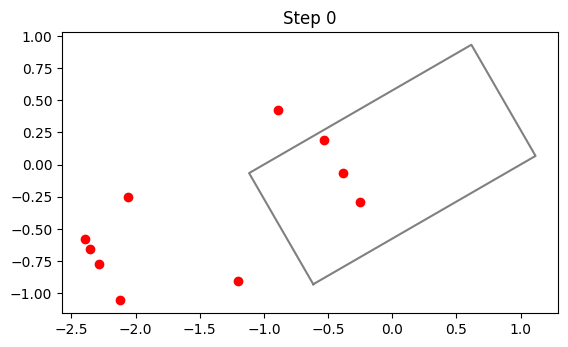

Action: ('horizontal', 2), Used: 2, Delta: 1.2532625815616525


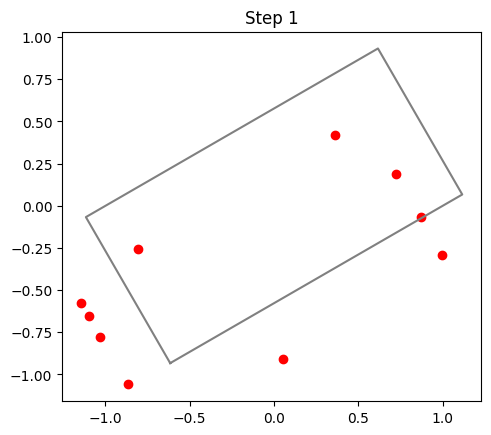

Action: ('vertical', 4), Used: 4, Delta: 0.44978124161522803


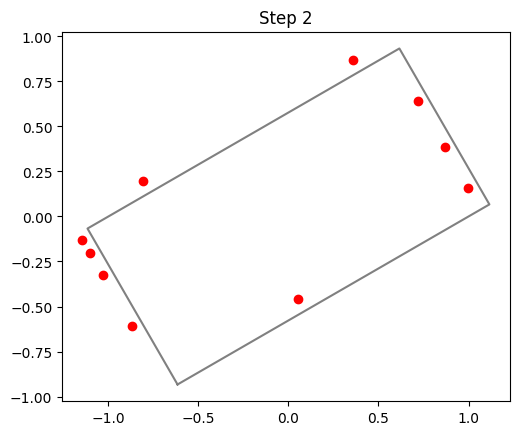

greedy eval: {'return': np.float64(0.14518838809764265), 'steps': 2, 'iters': 6, 'solved': True, 'final_mean_dist': 0.06094125992226379}


In [25]:

# Train SARSA
# Q, logs = train_sarsa(env, episodes=400, alpha=0.1, gamma=0.99,
#                       eps_start=0.2, eps_end=0.01, eps_decay=0.995, seed=0)
Q, logs = train_q_learning(env, episodes=400, alpha=0.1, gamma=1,
                      eps_start=0.2, eps_end=0.01, eps_decay=0.995, seed=0)

# Inspect a few metrics
print("last 5 episode returns:", [d['return'] for d in logs[-5:]])
print("last 5 iters used:    ", [d['iters']  for d in logs[-5:]])
print("success ratio:", sum(d['solved'] for d in logs[-50:]), "/ last 50")

# Evaluate/render one greedy episode and get the total optimizer iterations used
metrics = run_episode(env, Q, render=True)
print("greedy eval:", metrics)



In [30]:
rect_params = dict(center=(0, 0), width=2.0, height=1.0, theta=np.pi/6)
optimizer_params = dict(tau=0.1, loss="soft_l1", bounds=(-5, 5))
offsetX, offsetY = np.random.uniform(-2, 3), np.random.uniform(-2, 3)
rect = Rectangle(**rect_params)
rect.move(dx=offsetX, dy=offsetY)
points = rect.sample_points(num_points=10, jitter=0.0) 

env = RectangleEnv(rect_params=rect_params, optimizer_params=optimizer_params, points=points)


Action: ('horizontal', 6), Used: 6, Delta: 2.555895859213137
Action: ('horizontal', 2), Used: 2, Delta: 0.0
Action: ('horizontal', 6), Used: 6, Delta: 0.10433077029758306
Action: ('horizontal', 6), Used: 6, Delta: -0.01285136533673965
Action: ('vertical', 2), Used: 2, Delta: -2.23606797749979
Action: ('vertical', 2), Used: 2, Delta: -0.1598477441259202
Action: ('vertical', 6), Used: 3, Delta: -0.0058789627005048145
Action: ('vertical', 2), Used: 2, Delta: -3.412719923176392e-09
Action: ('vertical', 4), Used: 4, Delta: 0.0
Action: ('vertical', 4), Used: 4, Delta: 0.0
Action: ('horizontal', 2), Used: 2, Delta: -0.32553896944890415
Action: ('vertical', 2), Used: 2, Delta: -0.05834597036549764
Action: ('vertical', 2), Used: 2, Delta: -0.0007057562649209888
Action: ('horizontal', 6), Used: 4, Delta: -0.29819977856047525
Action: ('vertical', 2), Used: 2, Delta: -0.15587703306556608
Action: ('vertical', 6), Used: 3, Delta: -0.002940495195266162
Action: ('horizontal', 4), Used: 4, Delta: -0.20

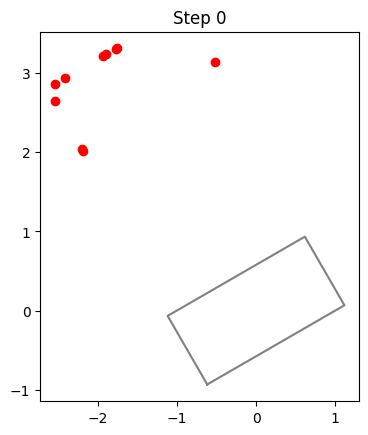

Action: ('vertical', 2), Used: 2, Delta: -2.23606797749979


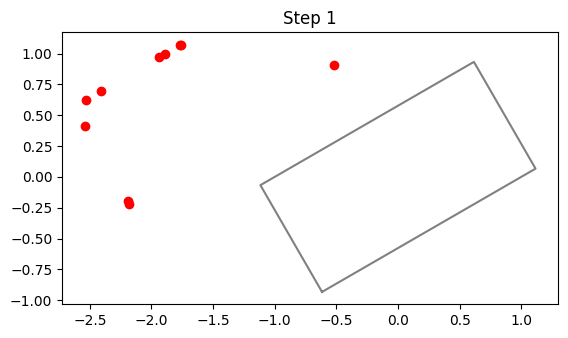

Action: ('vertical', 6), Used: 6, Delta: -0.6758633949247836


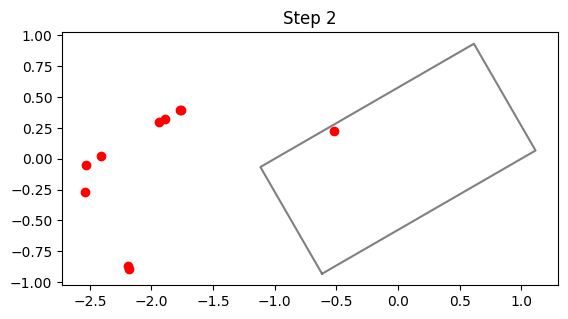

Action: ('horizontal', 6), Used: 5, Delta: 1.5098686161559618


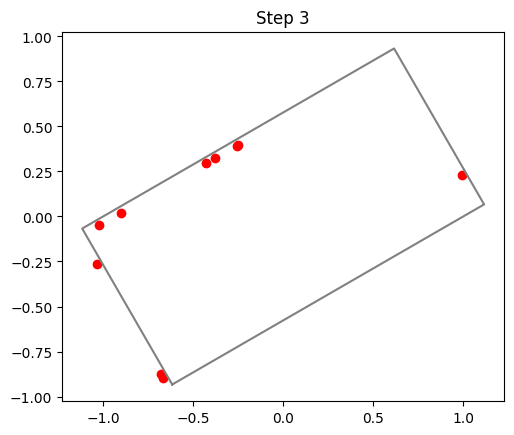

greedy eval: {'return': np.float64(1.6426980705350256), 'steps': 3, 'iters': 13, 'solved': True, 'final_mean_dist': 0.028989590251417823}


In [32]:

# # Train SARSA
Q, logs = train_sarsa(env, episodes=400, alpha=0.1, gamma=1,
                      eps_start=0.2, eps_end=0.01, eps_decay=0.995, seed=0)
# Q, logs = train_q_learning(env, episodes=400, alpha=0.1, gamma=1,
#                       eps_start=0.2, eps_end=0.01, eps_decay=0.995, seed=0)

# Inspect a few metrics
print("last 5 episode returns:", [d['return'] for d in logs[-5:]])
print("last 5 iters used:    ", [d['iters']  for d in logs[-5:]])
print("success ratio:", sum(d['solved'] for d in logs[-50:]), "/ last 50")

# Evaluate/render one greedy episode and get the total optimizer iterations used
metrics = run_episode(env, Q, render=True)
print("greedy eval:", metrics)